In [1]:
import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))

# @title Imports
import dataclasses
import datetime
import functools
import math
import re
from typing import Optional
from glob import glob

import cartopy.crs as ccrs
#from google.cloud import storage
from wofscast import autoregressive
from wofscast import casting
from wofscast import checkpoint
from wofscast import data_utils
from wofscast import my_graphcast as graphcast
from wofscast import normalization
from wofscast import rollout
from wofscast import xarray_jax
from wofscast import xarray_tree
from IPython.display import HTML
import ipywidgets as widgets
import haiku as hk
import jax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray #as xr

# For training the weights!
import optax

from wofscast.utils import count_total_parameters, save_model_params, load_model_params 


In [11]:
def create_static_vars(train_inputs):

    # Select the first time index for 'HGT' and 'XLAND' variables
    hgt_selected = train_inputs['HGT'].isel(time=0).drop('time')
    xland_selected = train_inputs['XLAND'].isel(time=0).drop('time')

    # Now, replace the 'HGT' and 'XLAND' in the original dataset with these selected versions
    train_inputs = train_inputs.drop_vars(['HGT', 'XLAND'])
    train_inputs['HGT'] = hgt_selected
    train_inputs['XLAND'] = xland_selected

    return train_inputs

In [12]:
# Initial params: mesh = 5, latent
mesh_size = 3
latent_size = 32
gnn_msg_steps = 4
hidden_layers = 1
radius_query_fraction_edge_length=5

DOMAIN_SIZE = 100

TRAIN_DATASET_PATH = '/work/mflora/wofs-cast-data/train_datasets'
NORM_STATS_PATH = '/work/mflora/wofs-cast-data/normalization_stats'

VARS_3D = ['U', 'V', 'W', 'T', 'GEOPOT']
VARS_2D = ['T2', 'COMPOSITE_REFL_10CM', 'UP_HELI_MAX', 'RAINNC']
STATIC_VARS = ['XLAND', 'HGT']

INPUT_VARS = VARS_3D + VARS_2D + STATIC_VARS
TARGET_VARS = VARS_3D + VARS_2D

EXTERNAL_FORCING_VARS = (
    "toa_incident_solar_radiation",
)
GENERATED_FORCING_VARS = (
    "year_progress_sin",
    "year_progress_cos",
    "day_progress_sin",
    "day_progress_cos",
)
FORCING_VARS = EXTERNAL_FORCING_VARS + GENERATED_FORCING_VARS

#FORCING_VARS = GENERATED_FORCING_VARS

# Not pressure levels, but just vertical array indices at the moment. 
PRESSURE_LEVELS = np.arange(0,40,2)

# Loads data from the past 20 minutes (2 steps) and 
# creates a target over the next 10-60 min. 
INPUT_DURATION = '20min'
# 170 min is the max, but keeping it lower for testing the workflow
eval_lead_times = slice('10min', '170min') 

# Weights used in the loss equation.
LOSS_WEIGHTS = {v : 1.0 for v in TARGET_VARS}
#VARIABLE_WEIGHTS['W'] = 2.0
#VARIABLE_WEIGHTS['UP_HELI_MAX'] = 2.0


TASK_WOFS = graphcast.TaskConfig(
      input_variables=INPUT_VARS,
      target_variables=TARGET_VARS,
      forcing_variables=FORCING_VARS,
      pressure_levels=PRESSURE_LEVELS,
      input_duration=INPUT_DURATION,
      n_vars_2D = len(VARS_2D),
      loss_weights = LOSS_WEIGHTS,
      domain_size = DOMAIN_SIZE
  )

MODEL_CONFIG = graphcast.ModelConfig(
      resolution=0,
      mesh_size=mesh_size,
      latent_size=latent_size,
      gnn_msg_steps=gnn_msg_steps,
      hidden_layers=hidden_layers,
      radius_query_fraction_edge_length=radius_query_fraction_edge_length)

In [13]:
# Load the data 
data_paths = glob(os.path.join('/work/mflora/wofs-cast-data/datasets/wrf*.nc'))
data_paths.sort()

path = data_paths[10]
dataset = xarray.load_dataset(path)

#dataset = dataset.expand_dims(dim='batch', axis=0)

# just load some data from the last dataset for evaluation. 
eval_inputs, eval_targets, eval_forcings = data_utils.extract_inputs_targets_forcings(
        dataset, target_lead_times=eval_lead_times,
        **dataclasses.asdict(TASK_WOFS))

eval_inputs = create_static_vars(eval_inputs)


#print("All Examples:  ", example_batch.dims.mapping)
print("*"*80)
print("Eval Inputs:   ", eval_inputs.dims.mapping)
print("Eval Targets:  ", eval_targets.dims.mapping)
print("Eval Forcings: ", eval_forcings.dims.mapping)

********************************************************************************
Eval Inputs:    {'time': 2, 'level': 20, 'lat': 100, 'lon': 100}
Eval Targets:   {'time': 17, 'level': 20, 'lat': 100, 'lon': 100}
Eval Forcings:  {'time': 17, 'lat': 100, 'lon': 100}


In [16]:
eval_inputs = eval_inputs.expand_dims(dim='batch', axis=0)
eval_targets = eval_targets.expand_dims(dim='batch', axis=0)
eval_forcings = eval_forcings.expand_dims(dim='batch', axis=0)


In [4]:
# Load the normalization datasets
mean_by_level = xarray.load_dataset(os.path.join(NORM_STATS_PATH, 'mean_by_level.nc'))
stddev_by_level = xarray.load_dataset(os.path.join(NORM_STATS_PATH, 'stddev_by_level.nc'))
diffs_stddev_by_level = xarray.load_dataset(os.path.join(NORM_STATS_PATH, 'diffs_stddev_by_level.nc'))

In [17]:
# @title Build jitted functions, and possibly initialize random weights

# Load saved model params and test! 
base_path = '/work/mflora/wofs-cast-data/model/'
params_path = os.path.join(base_path, 'params.npz')

model_params = load_model_params(params_path)
state = {}

def construct_wrapped_graphcast(
    model_config: graphcast.ModelConfig,
    task_config: graphcast.TaskConfig):
    """Constructs and wraps the GraphCast Predictor."""

    # Deeper one-step predictor.
    predictor = graphcast.GraphCast(model_config, task_config)

    # Modify inputs/outputs to `graphcast.GraphCast` to handle conversion to
    # from/to float32 to/from BFloat16.
    predictor = casting.Bfloat16Cast(predictor)

    # Modify inputs/outputs to `casting.Bfloat16Cast` so the casting to/from
    # BFloat16 happens after applying normalization to the inputs/targets.
    predictor = normalization.InputsAndResiduals(
      predictor,
      diffs_stddev_by_level=diffs_stddev_by_level,
      mean_by_level=mean_by_level,
      stddev_by_level=stddev_by_level)

    # Wraps everything so the one-step model can produce trajectories.
    predictor = autoregressive.Predictor(predictor, gradient_checkpointing=True)
    
    return predictor


@hk.transform_with_state
def run_forward(model_config, task_config, inputs, targets_template, forcings):
  predictor = construct_wrapped_graphcast(model_config, task_config)
  return predictor(inputs, targets_template=targets_template, forcings=forcings)

# Jax doesn't seem to like passing configs as args through the jit. Passing it
# in via partial (instead of capture by closure) forces jax to invalidate the
# jit cache if you change configs.
def with_configs(fn):
  return functools.partial(
      fn, model_config=MODEL_CONFIG, task_config=TASK_WOFS)

# Always pass params and state, so the usage below are simpler
def with_params(fn):
  return functools.partial(fn, params=model_params, state=state)

# Our models aren't stateful, so the state is always empty, so just return the
# predictions. This is requiredy by our rollout code, and generally simpler.
def drop_state(fn):
  return lambda **kw: fn(**kw)[0]

init_jitted = jax.jit(with_configs(run_forward.init))

In [18]:
# Always pass params and state, so the usage below are simpler
def with_model_params(fn):
  return functools.partial(fn, params=model_params, state=state)

run_forward_jitted = drop_state(with_model_params(jax.jit(with_configs(
    run_forward.apply))))

# @title Autoregressive rollout (keep the loop in JAX)
print("Inputs:  ", eval_inputs.dims.mapping)
print("Targets: ", eval_targets.dims.mapping)
print("Forcings:", eval_forcings.dims.mapping)

predictions = rollout.chunked_prediction(
    run_forward_jitted,
    rng=jax.random.PRNGKey(0),
    inputs=eval_inputs,
    targets_template=eval_targets * np.nan,
    forcings=eval_forcings)

predictions

Inputs:   {'batch': 1, 'time': 2, 'level': 20, 'lat': 100, 'lon': 100}
Targets:  {'batch': 1, 'time': 17, 'level': 20, 'lat': 100, 'lon': 100}
Forcings: {'batch': 1, 'time': 17, 'lat': 100, 'lon': 100}
In my_graphcast, Line 816 Excluding forcings!!


<xarray.Dataset>
Dimensions:              (time: 17, batch: 1, lat: 100, lon: 100, level: 20)
Coordinates:
  * time                 (time) timedelta64[ns] 00:10:00 00:20:00 ... 02:50:00
  * lat                  (lat) float32 32.8 32.83 32.85 ... 35.45 35.48 35.51
  * lon                  (lon) float32 80.31 80.34 80.37 ... 83.34 83.37 83.41
  * level                (level) int64 0 2 4 6 8 10 12 ... 26 28 30 32 34 36 38
Dimensions without coordinates: batch
Data variables:
    COMPOSITE_REFL_10CM  (time, batch, lat, lon) float32 0.2166 ... 0.1784
    GEOPOT               (time, batch, level, lat, lon) float32 -0.008965 ......
    RAINNC               (time, batch, lat, lon) float32 -0.1594 ... 18.54
    T                    (time, batch, level, lat, lon) float32 299.9 ... 404.8
    T2                   (time, batch, lat, lon) float32 298.7 298.5 ... 286.9
    U                    (time, batch, level, lat, lon) float32 0.893 ... 25.22
    UP_HELI_MAX          (time, batch, lat, lon) float32 -0.2658 ... 6.34
    V                    (time, batch, level, lat, lon) float32 4.22 ... -2.008
    W                    (time, batch, level, lat, lon) float32 -0.0122 ... -...

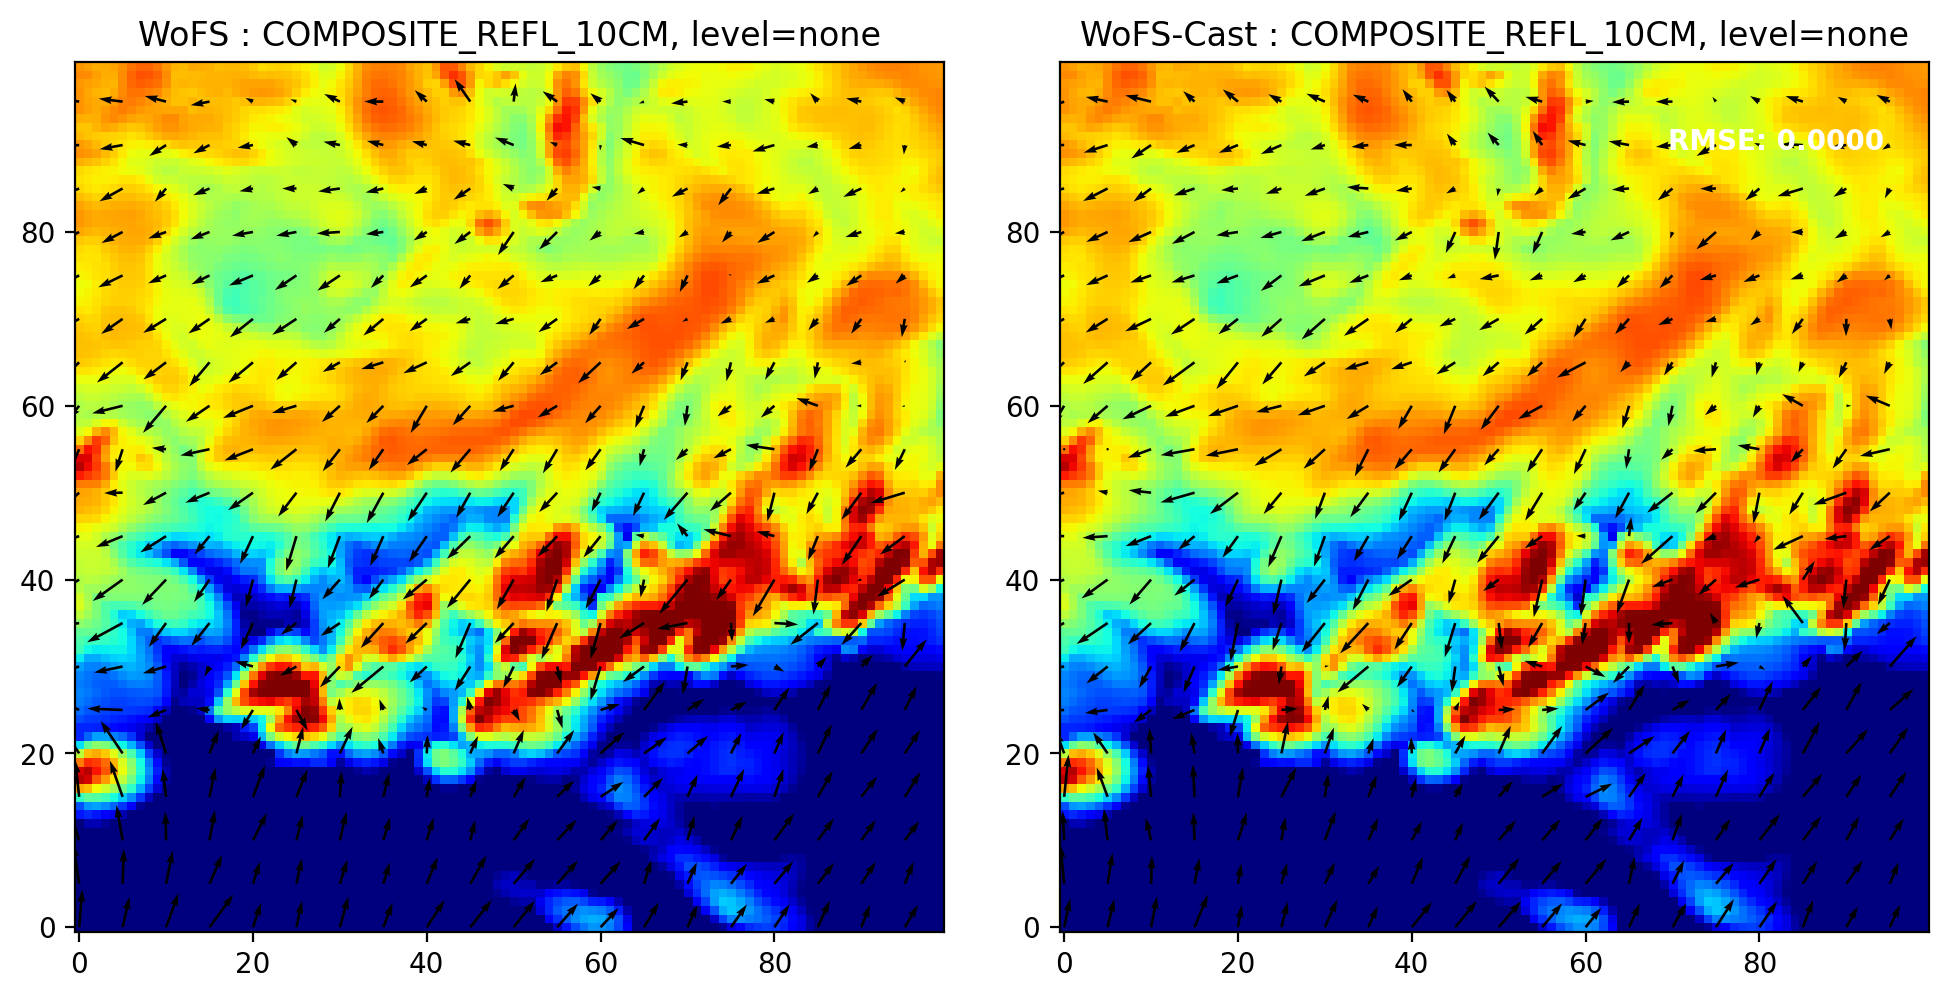

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

preds = predictions.squeeze(dim='batch', drop=True)
targets = eval_targets.squeeze(dim='batch', drop=True)

init_ds = eval_inputs.squeeze(dim='batch', drop=True)
init_ds = init_ds.isel(time=[0])

var = 'COMPOSITE_REFL_10CM'
level = 'none'

# Function to get target and prediction pair with the selected level
def get_target_and_pred_pair(preds, targets, t, level=0):
    if level == 'max':
        zs = [targets[var][t].max(dim='level').values, preds[var][t].max(dim='level').values]
    elif level == 'min': 
        zs = [targets[var][t].min(dim='level').values, preds[var][t].min(dim='level').values]
    elif level == 'none':
        zs = [targets[var][t].values, preds[var][t].values]
    else:
        zs = [targets[var][t, level].values, preds[var][t, level].values]
    return zs 


fig, axes = plt.subplots(dpi=200, figsize=(10, 6), ncols=2)
plt.tight_layout()

titles = [f'WoFS : {var}, level={level}', f'WoFS-Cast : {var}, level={level}']

# Determine global min and max values for consistent color scaling
zs = get_target_and_pred_pair(init_ds, init_ds, t=0, level=level)
global_min = np.percentile(zs, 1)
global_max = np.percentile(zs, 99)



# Update function for the animation
def update(t):
    for ax in axes:
        ax.clear()

    if t==0:
        zs = get_target_and_pred_pair(init_ds, init_ds, t=0, level=level)
    else:    
        zs = get_target_and_pred_pair(preds, targets, t=t, level=level)
    
    rmse = np.sqrt(np.mean((zs[0]-zs[1])**2))

    u_pred, v_pred = preds['U'][t].isel(level=0).values, preds['V'][t].isel(level=0).values
    u_tar, v_tar = targets['U'][t].isel(level=0).values, targets['V'][t].isel(level=0).values
    
    u_pred = u_pred[::5, ::5]
    v_pred = v_pred[::5, ::5]
    
    u_tar = u_tar[::5, ::5]
    v_tar = v_tar[::5, ::5]
    
    wind_pred = (u_pred, v_pred)
    wind_tar = (u_tar, v_tar)
    
    winds = [wind_tar, wind_pred]
    
    x,y = np.meshgrid(np.arange(DOMAIN_SIZE), np.arange(DOMAIN_SIZE))
    
    x = x[::5, ::5]
    y = y[::5, ::5]
    
    color='white'
    for i, (ax, z, wind) in enumerate(zip(axes, zs, winds)):
        if var in ['REFL_10CM', 'UP_HELI_MAX']:
            z = np.ma.masked_where(z < 5, z)
            color = 'black'

        im = ax.imshow(z, origin='lower', aspect='equal', cmap='jet', vmin=global_min, vmax=global_max)
 
        u,v = wind

        ax.quiver(x,y, u, v)
        
        
        ax.set_title(titles[i])
        if i == 1:
            ax.annotate(f'RMSE: {rmse:.4f}', xy=(0.7, 0.9), xycoords='axes fraction', 
                        weight='bold', color=color)

# Total number of frames
N = targets[var].shape[0]  # Assuming 't' dimension is second

# Create animation
anim = FuncAnimation(fig, update, frames=N, interval=200)

# To display the animation in a Jupyter notebook
from IPython.display import HTML
HTML(anim.to_jshtml())

# Optionally, to save the animation
#anim.save("wofscast.gif", writer="pillow", fps=5)